# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
!pip install plotly

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix,roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV #score de cross validation

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [3]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [4]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [5]:
desc = data.describe(include='all')
display(desc)
print(data.shape)

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


(284580, 6)


In [6]:
display(100*data.isnull().sum()/data.shape[0]) #no missing values

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

# Explore dataset

In [7]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
#data_sample = data.sample(10000)

In [8]:
round(data.country.value_counts(normalize=True).mul(100),2) # Majorité des utilisateurs sont localisés aux US

US         56.27
China      24.29
UK         15.34
Germany     4.11
Name: country, dtype: float64

In [9]:

round(data.new_user.value_counts(normalize=True).mul(100), 2) # La majorité des utilisateurs sont des nouveaux inscrits

1    68.55
0    31.45
Name: new_user, dtype: float64

In [10]:
round(data.source.value_counts(normalize=True).mul(100),2) # le SEO semble prédominant comme source de trafic

Seo       49.01
Ads       28.12
Direct    22.87
Name: source, dtype: float64

In [11]:
round(data.converted.value_counts(normalize=True).mul(100),2) # Le taux de conversion est faible, le dataset est donc nettement déséquilibré

0    96.77
1     3.23
Name: converted, dtype: float64

Visualisation des variables

In [12]:
mea = data['age'].mean()
std = data['age'].std()
min = round((mea - 2*std))
max = round((mea + 2*std))
print("âge minimum à 2 écart type de la moyenne:", min, "\n"  "âge maximum à 2 écart type de la moyenne:",max)

âge minimum à 2 écart type de la moyenne: 14 
âge maximum à 2 écart type de la moyenne: 47


In [13]:

print("L'âge moyen des utilisateurs : {}".format(round(data['age'].mean())))
print("L'écart type : {}".format(round(data['age'].std())))

L'âge moyen des utilisateurs : 31
L'écart type : 8


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



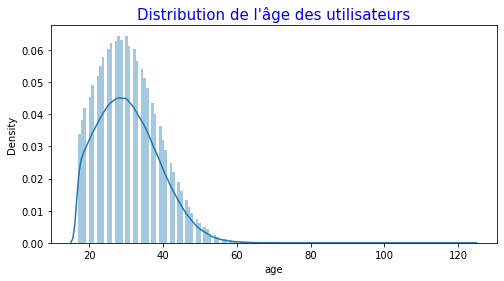

In [14]:

fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(data.age, ax=ax,norm_hist=True, bins=150)
plt.title("Distribution de l'âge des utilisateurs", fontsize=15, color='b')
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


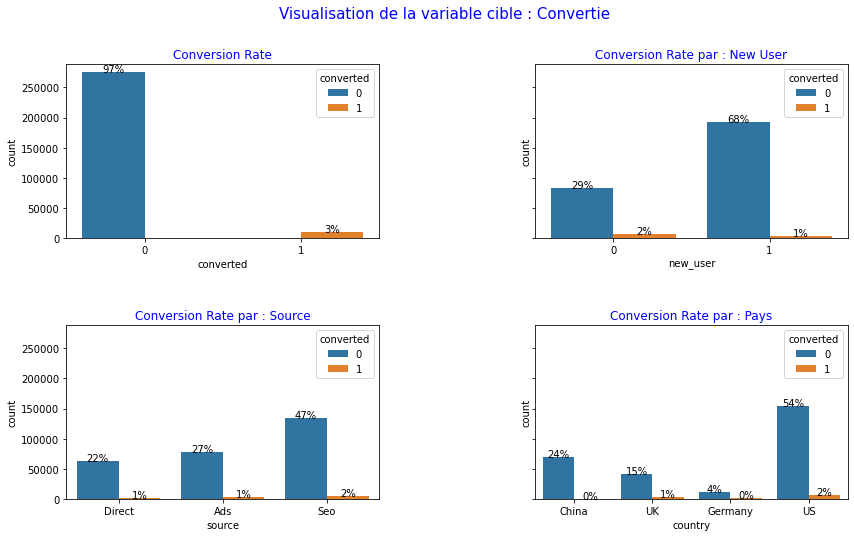

In [15]:

fig, ax = plt.subplots(2,2, figsize=(14,8), constrained_layout=False, sharey=True, )
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle("Visualisation de la variable cible : Convertie", fontsize=15, color='b')

sns.countplot(data =data, x ="converted", hue="converted", ax = ax[0, 0])
ax[0,0].set_title("Conversion Rate",fontsize=12, color='b')

sns.countplot(data =data, x ="new_user",  hue="converted", ax = ax[0, 1])
ax[0,1].set_title("Conversion Rate par : New User", fontsize=12, color='b')

sns.countplot(data =data, x ="country", hue="converted", ax = ax[1, 1])
ax[1,1].set_title("Conversion Rate par : Pays",fontsize=12, color='b')

sns.countplot(data =data, x ="source",  hue="converted", ax = ax[1, 0])
ax[1,0].set_title("Conversion Rate par : Source",fontsize=12, color='b')

for i in range(2):
    for j in range(2):
        for p in ax[i, j].patches:
          total = float(len(data))
          height = p.get_height()
          ax[i,j].text(p.get_x()+p.get_width()/2.,
          height + 3, '{0:.0%}'.format(height/total), ha="center")
plt.show()

Nous pouvons constater que le taux de conversion est très faible(<5%)
Il semble également qu'il est un peu plus important aux USA en raison d'un trafic plus important
Le SEO a une performance légèrement meilleure que les autres canaux d'acquisition

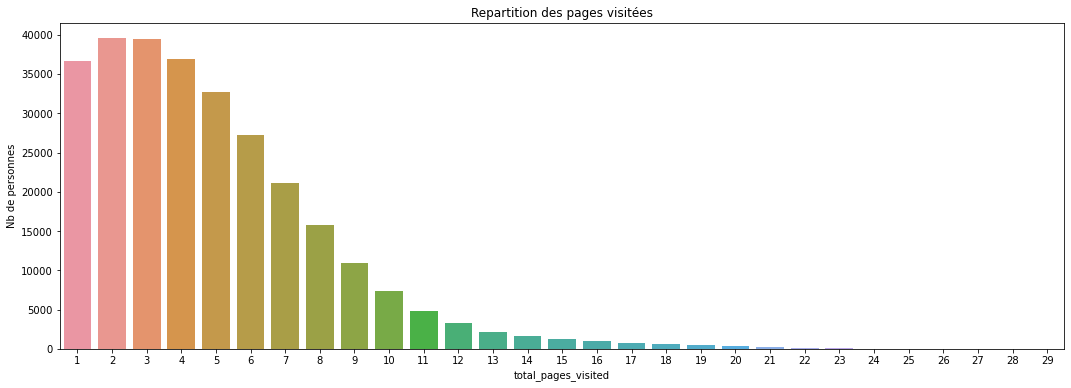

In [16]:
plt.figure(figsize=(18,6))
ax = sns.countplot(x = data["total_pages_visited"]);
ax.set_ylabel("Nb de personnes")
ax.set_title("Repartition des pages visitées")
plt.show();

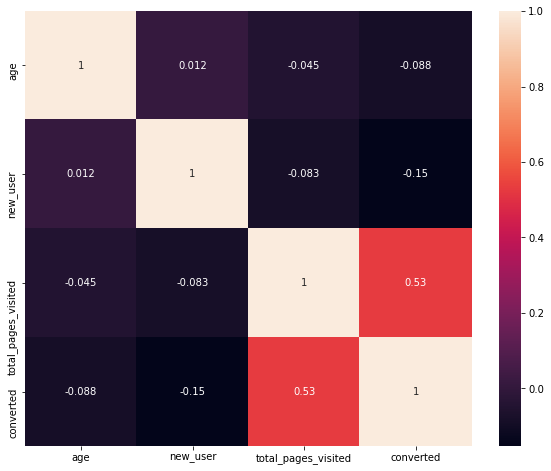

In [17]:
# Correlation matrix

plt.figure(figsize= (10,8))
sns.heatmap(data.corr(), annot= True,);

Logiquement, la plus forte corrélation se situe entre le trafic total et le nombre de conversions

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [18]:
features_list = ['country','age','new_user','source','total_pages_visited']
numeric_indices = [1,4]
categorical_indices = [0,2,3]
target_variable = 'converted'

In [19]:
X = data.loc[:, features_list]
Y = data[target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [20]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [21]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.to_list()
Y_test = Y_test.to_list()
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['US' 29 1 'Seo' 4]
 ['US' 23 0 'Direct' 7]
 ['UK' 33 1 'Seo' 11]
 ['China' 25 1 'Seo' 5]
 ['US' 40 0 'Seo' 1]]
[['US' 20 1 'Ads' 7]
 ['US' 31 1 'Seo' 5]]

[0, 0, 0, 0, 0]
[0, 0]


## Training pipeline

In [22]:
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print()
print(X_train[0:5,:])

# Normalization
numeric_transformer = StandardScaler()

# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first')

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)
X_test = featureencoder.transform(X_test)
print("...Done")



Encoding categorical features and standardizing numerical features...

[['US' 29 1 'Seo' 4]
 ['US' 23 0 'Direct' 7]
 ['UK' 33 1 'Seo' 11]
 ['China' 25 1 'Seo' 5]
 ['US' 40 0 'Seo' 1]]
...Done


In [23]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score 
print("3-fold cross-validation...")
regressor = LogisticRegression()
scores = cross_val_score(regressor, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

3-fold cross-validation...
The cross-validated R2-score is :  0.9862824161922834
The standard deviation is :  0.0003079095890140569


In [24]:
# Perform grid search
print("Grid search...")

# Grid of values to be tested
params = {
    'C': np.arange(1,3,0.1) # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3,scoring="f1") # cv : the number of folds (repetitions) to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
# Predictions on training set
# The model has already be re-trained on all the training set at the end of the grid search, so we can directly use it !
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print(sklearn.metrics.classification_report(Y_train, gridsearch.predict(X_train)))

Grid search...
...Done.
Best hyperparameters :  {'C': 2.6000000000000014}
Predictions on training set...
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220334
           1       0.86      0.69      0.77      7330

    accuracy                           0.99    227664
   macro avg       0.92      0.84      0.88    227664
weighted avg       0.99      0.99      0.99    227664



In [25]:
## Test pipeline

In [26]:
# Visualize ROC curves
probas_train = gridsearch.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(Y_train, probas_train)
fig = go.Figure(
    data = go.Scatter(
        name = 'train',
        x = fpr, 
        y = tpr, 
        mode = 'lines'
    ),
    layout = go.Layout(
        title = go.layout.Title(text = "ROC curve", x = 0.5),
        xaxis = go.layout.XAxis(title = 'False Positive Rate'),
        yaxis = go.layout.YAxis(title = 'True Positive Rate')
    )
)

probas_test = gridsearch.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = roc_curve(Y_test, probas_test)
fig.add_trace(go.Scatter(
    name = 'test',
    x = recalls, 
    y = precisions, 
    mode = 'lines'
    )
)
fig.show()

In [27]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print(sklearn.metrics.classification_report(Y_test, gridsearch.predict(X_test)))

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

f1-score on test set :  0.7580596565230492
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55066
           1       0.86      0.68      0.76      1850

    accuracy                           0.99     56916
   macro avg       0.92      0.84      0.88     56916
weighted avg       0.99      0.99      0.99     56916



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [28]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

gridsearch.fit(X,Y)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9])},
             scoring='f1')

In [29]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country','age','new_user','source','total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]


In [30]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.          1.          0.          0.          0.          1.
  -0.3112874   3.32677112]
 [ 0.          1.          0.          1.          1.          0.
  -1.03716308  0.03803388]
 [ 0.          0.          0.          1.          0.          1.
   0.17262971 -1.15787057]
 [ 0.          0.          1.          1.          0.          0.
   0.17262971  0.33701   ]
 [ 0.          0.          0.          0.          0.          1.
  -0.67422524 -0.55991834]]


In [31]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': gridsearch.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**